# Hand-written digit classification by different classification methods
#### Version 2 (Sep 2020) / tested for python 3.7.6

### General information

***Goal:*** Implementation of different classification models and comparison of their performance in predicting the correct digit from given images containing hand-written digits.

***Note:*** In this current version I implemented 2 models: multiclass (OvR) logistic regression, and neural network. In the next versions I plan to add other classification models (SVM, kNN), and compare the performances between the models.

***Dataset:*** Images are taken from the MNIST handwritten digit database (loaded via sklearn.datasets)


***Logistic regression model parameters:***
- multi-class technique: One-Vs-Rest
- optimization algorithm: L-BFGS
- regularization method: L2/RIDGE

***Neural network model parameters:***
- model: Sequential (2 hidden layers x 64 units) 
- optimizer: Stochastic
- regulatization: Dropout layer (0.1)
- loss function: Categorical crossentropy

In [11]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['figure.dpi'] = 100

In [12]:
# Data inspection functions:
############################

def display_data(array, example_width=None):
    """
    Plots images from array (rows=images, columns=pixels)
    :param array: images-array of m images (rows) x n pixels (cols)
    :param example_width: number of pixels in an image's row (optional)
    :return: display_array: matrix containing all images for visualization
    """
    [m, n] = array.shape
    try:
        example_height = int(n / example_width)
    except TypeError:
        example_width = int(round(math.sqrt(array.shape[1] - 1)))
        example_height = int(n / example_width)

    display_rows = math.floor(np.sqrt(m))
    display_cols = math.ceil(m / display_rows)
    filler = 1
    display_array = - np.ones(
        (filler + display_rows * (example_height + filler), filler + display_cols * (example_width + filler)))

    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex + 1 > m:
                break
            max_val = max(abs(array[curr_ex, :]))

            row_start = filler + j * (example_height + filler)
            row_end = filler + j * (example_height + filler) + example_height
            col_start = filler + i * (example_width + filler)
            col_end = filler + i * (example_width + filler) + example_width

            display_array[row_start:row_end, col_start:col_end] = \
                np.reshape(array[curr_ex, :], (example_height, example_width)) / max_val

            curr_ex += 1

        if curr_ex + 1 > m:
            break

    plt.imshow(display_array, cmap='gray', vmin=-1, vmax=1)  # cmap=plt.cm.binary
    plt.axis('off')
    plt.show()

def classes_distrib(y_values, y_title):
    plt.figure(figsize=(6,3))
    sns.countplot(x=y_values, palette=['#86bf91'])
    plt.xlabel("Class")
    plt.title("Classes distribution: {} (n={})".format(y_title, len(y_values)))
    plt.ylabel("Frequency")
    plt.show()

    
# Performance evaluation functions (used to evaluate all models):
#################################################################

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from IPython.display import display, clear_output
from collections import OrderedDict

y_scores = OrderedDict()  # will store the prediction probabilities of each model (to compare between the models)

def eval_accuracy(actual_y, predicted_y):  # Correct/Total
    return accuracy_score(actual_y, predicted_y)  # same as: np.mean(actual_y == predicted_y)

def confus_matr(actual_y, predicted_y):
    n_classes = len(np.unique(actual_y))
    cm = confusion_matrix(actual_y, predicted_y)
    cm_df = pd.DataFrame(cm)
    col_list = ['Predicted ' + str(i) for i in range(n_classes)]
    cm_df.columns = col_list
    indices = {i: 'Actual ' + str(i) for i in range(n_classes)}
    cm_df = cm_df.rename(index=indices)
    return cm_df

def create_recall_precision_scores(actual_y, predicted_y):
    performance_df = pd.DataFrame(np.unique(y_validate).astype(int), columns=['Classes'])
    performance_df['Recall'] = performance_df.apply(lambda row: measure_recall(row, actual_y, predicted_y), axis=1)
    performance_df['Precision'] = performance_df.apply(lambda row: measure_precision(row, actual_y, predicted_y), axis=1)
    return performance_df

def measure_recall(row, actual_y, predicted_y):
    result = (predicted_y[actual_y == row['Classes']] == row['Classes']).sum() / len(predicted_y[actual_y == row['Classes']])  # TP / (TP + FN)  ("recall", "sensitivity")
    return result

def measure_precision(row, actual_y, predicted_y):
    result = (predicted_y[actual_y == row['Classes']] == row['Classes']).sum() / (predicted_y == row['Classes']).sum()  # TP / (TP + FP)  ("precision", "positive predictive value")
    return result

def binarize_classes(y_values):  # transform target vector (examples x explicit value) to binarized matrix (examples x classes)
    y_binarized = label_binarize(y_values, classes=np.unique(y_values))
    return y_binarized

def precision_recall_curves(y_binarized, y_score):  # precision-recall AUC, grouped-by classes (including f1-scores areas)
    n_classes = y_binarized.shape[1]
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_binarized[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_binarized[:, i], y_score[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(y[45] + 0.02, 1.05))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision vs. Recall curve")
    plt.show()

def micro_avg_prec_recall(ax, y_binarized, y_score, model_name):  # A "micro-average": total precision-recall AUC across classes 
    # precision recall curve
    precision = dict()
    recall = dict()
    average_precision = dict()
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_binarized.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_binarized, y_score, average="micro")
    plt.step(recall['micro'], precision['micro'], where='post', label='{0}: AP={1:0.2f}'.format(model_name, average_precision["micro"]))
    plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'.format(average_precision["micro"]))

def set_ax_params(ax):
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    return ax
    
def analyze_model_performance(actual_y, predicated_y, y_score, model_name):
    y_binarized = binarize_classes(actual_y)  
    
    # 1. accuracy score:
    print('Accuracy score, Model: {}'.format(model_name))
    model_accuracy = eval_accuracy(actual_y, predicated_y)
    print(str(round(model_accuracy * 100, 1)) + '\n'*2)

    # 2. confusion matrix:
    print('Confusion matrix, Model: {}'.format(model_name))
    cm_df = confus_matr(actual_y, predicated_y)
    display(cm_df)
    print('\n'*2)

    # 3. precision-recall scores per class
    print('Precision & recall scores for each class, Model: {}'.format(model_name))
    performance_df = create_recall_precision_scores(actual_y, predicated_y)
    display(performance_df)
    print('\n'*2)
    
    # 4. precision-recall curves by classes
    print('Precision-recall curves for each class, Model: {}'.format(model_name))
    precision_recall_curves(y_binarized, y_score)
    print('\n'*2)

    # 5. micro-avg. precision-recall curve
    fig, ax = plt.subplots()
    ax = set_ax_params(ax)
    print('Micro-averaged precision-recall curve, Model: {}'.format(model_name))
    micro_avg_prec_recall(ax, y_binarized, y_score, model_name)
    
def plt_training_progress(history, var_list, y_label):  # plot loss & accuracy for training & validation sets along training
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot(np.sqrt(history[var_list[0]]), 'r', label='train')
    ax.plot(np.sqrt(history[var_list[1]]), 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)  # r'Accuracy'
    ax.legend()
    ax.tick_params(labelsize=10)

## 1. Load data

In [13]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)  # takes about a min to load...
mnist.target = mnist.target.astype(np.int8)

## 2. Inspect data

### 2.1. Plot random images from the dataset

Labels of plotted images: [8 6 1 3 9 3 3 1 7 2 2 3 2 6 6 3 2 1 8 3 8 3 7 1 9]


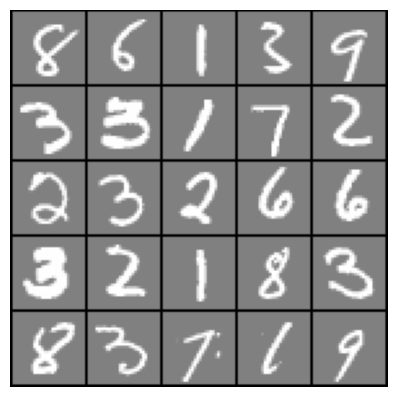

In [14]:
imgs_num = 25  # number of images to display
rand_imgs = np.random.permutation(mnist.data.shape[0])[0:imgs_num] 
print('Labels of plotted images: {}'.format(mnist.target[rand_imgs]))
display_data(mnist.data[rand_imgs, :])

### 2.2. Plot classes distribution (check if data is balanced)

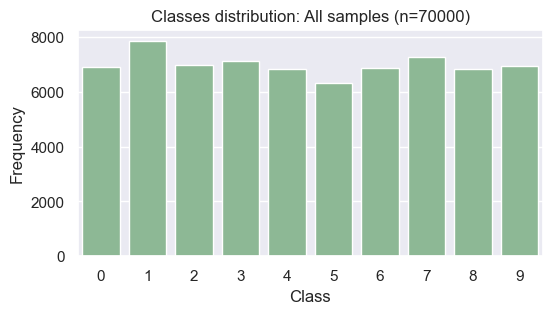

In [15]:
classes_distrib(mnist.target, 'All samples')

## 3. Data pre-processing

### 3.1. shuffle, normalize, split to train / validation / test subsets

In [16]:
# pre-training steps
data_mat = np.column_stack([mnist.target, mnist.data])
np.random.shuffle(data_mat)  # randomly shuffle the dataset
y = data_mat[:,0]
X = data_mat[:,1:]
X_norm = X / np.abs(X).max(axis=1).reshape(len(X),1)  # normalize (divide each image values by its max value)
X_train, X_validate, X_test = np.split(X_norm, [int(len(X_norm)*0.6), int(len(X_norm)*0.8)])  # split X to train/val/test arrays (0.6/0.2/0.2 ratio)
y_train, y_validate, y_test = np.split(y, [int(len(y)*0.6), int(len(y)*0.8)])  # split y to similar groups as X

### 3.2. Plot classes distribution of the validation set
(to check if data is balanced - relevant for preformance evaluation stage, to decide between micro-average and macro-average)

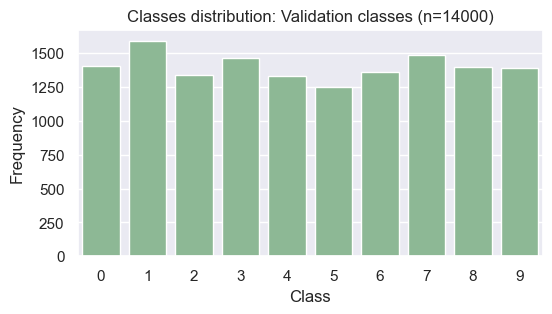

In [17]:
classes_distrib(y_validate.astype(int), 'Validation classes')  # show once that the validation classes are balanced - for the micro-avg curve

## 4. Train, predict and evaluate different classification models

### 4.1. Logistic regression

#### 4.1.1. Train model
(~2 min. on a reasonable laptop)

In [18]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500, random_state=0, multi_class='ovr').fit(X_train, y_train)

#### 4.1.2. Generate predictions using the validation set

In [19]:
y_predicted = clf.predict(X_validate)
y_score_logit = clf.predict_proba(X_validate)
y_scores['logit'] = y_score_logit

#### 4.1.3 Performance evaluation

Accuracy score, Model: Logistic regression
91.5


Confusion matrix, Model: Logistic regression


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,1363,0,3,2,7,9,15,0,3,2
Actual 1,0,1559,3,3,1,7,3,2,12,3
Actual 2,13,21,1176,22,16,2,17,22,45,2
Actual 3,4,8,33,1313,1,47,6,9,23,17
Actual 4,1,5,8,1,1233,3,12,6,11,49
Actual 5,16,9,6,43,20,1081,21,3,34,15
Actual 6,12,6,14,5,8,28,1277,1,7,0
Actual 7,4,7,11,9,10,2,2,1399,7,33
Actual 8,16,33,17,37,8,51,14,5,1193,25
Actual 9,7,13,5,24,38,10,0,62,12,1217





Precision & recall scores for each class, Model: Logistic regression


,Classes,Recall,Precision
0,0,0.970798,0.949164
1,1,0.978657,0.938591
2,2,0.880240,0.921630
3,3,0.898700,0.899931
4,4,0.927765,0.918778
5,5,0.866186,0.871774
6,6,0.940353,0.934162
7,7,0.942722,0.927104
8,8,0.852752,0.885672
9,9,0.876801,0.892883





Precision-recall curves for each class, Model: Logistic regression


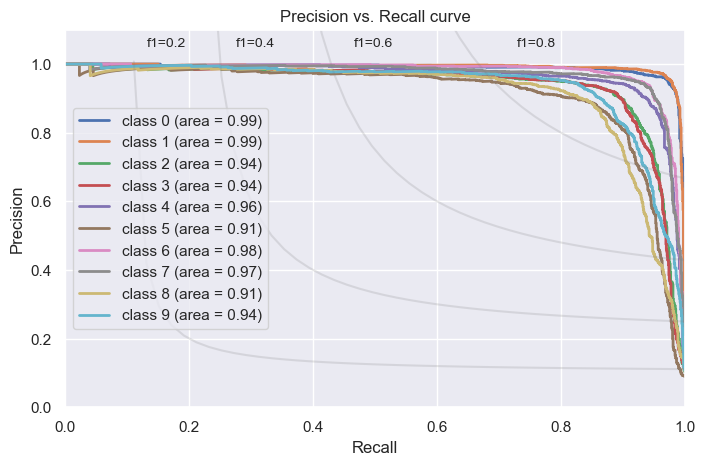




Micro-averaged precision-recall curve, Model: Logistic regression


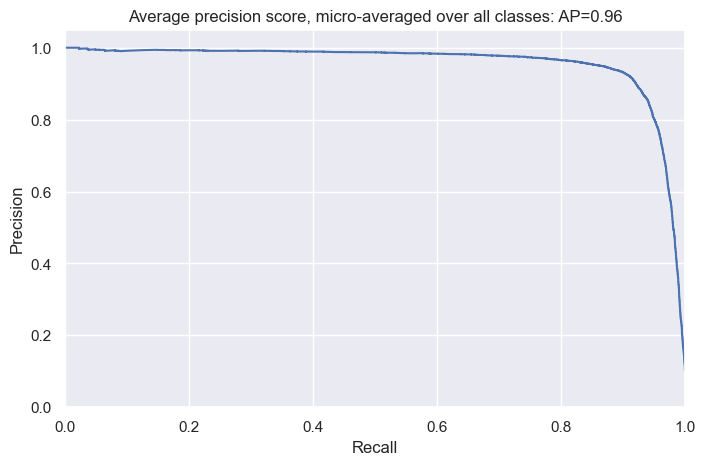

In [20]:
analyze_model_performance(y_validate, y_predicted, y_score_logit, 'Logistic regression')

### 4.2. Neural Network

In [21]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from keras.optimizers import SGD
# from keras.optimizers import RMSprop  # will be implemented in a later version
# from keras.callbacks import LearningRateScheduler  # will be implemented in a later version
# from keras.callbacks import History  # will be implemented in a later version

print('TensorFlow version: {}'.format(tf.__version__)) 
print('Implemented Keras API version: {}'.format(tf.keras.__version__))

TensorFlow version: 2.1.0
Implemented Keras API version: 2.2.4-tf


In [22]:
# set hyper-params & optimizer action mode:
epochs = 60
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# define network topology:
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

lr_model = Sequential()
lr_model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', 
                input_dim = input_dim)) 
lr_model.add(Dropout(0.1))
lr_model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

# compile model
lr_model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

#### 4.2.1. Train model
(~10 min. on a reasonable laptop for the following topology & hyperparams)

Train on 42000 samples, validate on 14000 samples
Epoch 1/60
42000/42000 [==============================] - 11s 257us/step - loss: 0.4007 - acc: 0.8770 - val_loss: 0.2022 - val_acc: 0.9404
Epoch 2/60
42000/42000 [==============================] - 10s 243us/step - loss: 0.1887 - acc: 0.9422 - val_loss: 0.1608 - val_acc: 0.9491
Epoch 3/60
42000/42000 [==============================] - 10s 245us/step - loss: 0.1553 - acc: 0.9515 - val_loss: 0.1481 - val_acc: 0.9541
Epoch 4/60
42000/42000 [==============================] - 10s 248us/step - loss: 0.1394 - acc: 0.9572 - val_loss: 0.1426 - val_acc: 0.9564
Epoch 5/60
42000/42000 [==============================] - 10s 246us/step - loss: 0.1322 - acc: 0.9589 - val_loss: 0.1382 - val_acc: 0.9572
Epoch 6/60
42000/42000 [==============================] - 10s 248us/step - loss: 0.1234 - acc: 0.9612 - val_loss: 0.1378 - val_acc: 0.9569
Epoch 7/60
42000/42000 [==============================] - 10s 245us/step - loss: 0.1201 - acc: 0.9623 - val_loss: 0.

42000/42000 [==============================] - 10s 248us/step - loss: 0.0796 - acc: 0.9748 - val_loss: 0.1149 - val_acc: 0.9653
Epoch 60/60
42000/42000 [==============================] - 11s 250us/step - loss: 0.0775 - acc: 0.9760 - val_loss: 0.1149 - val_acc: 0.9659
Wall time: 10min 51s


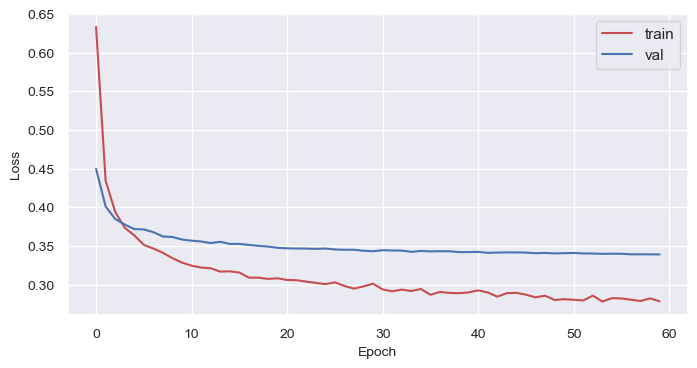

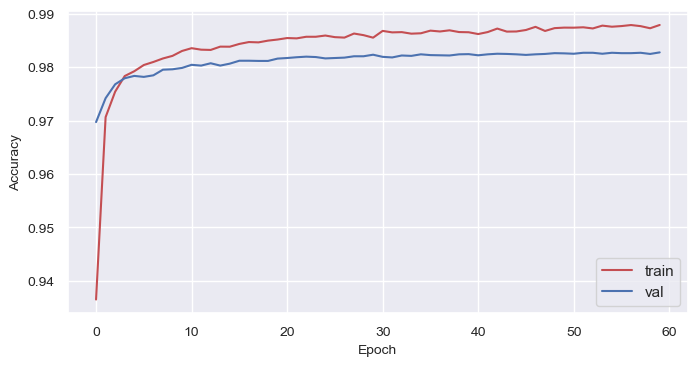

In [23]:
%%time
# Fit the model
batch_size = int(input_dim/100)

y_train_binarized = binarize_classes(y_train)
y_validate_binarized = binarize_classes(y_validate)
lr_model_history = lr_model.fit(X_train, y_train_binarized,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_validate, y_validate_binarized))

# plot progress along training epochs (loss & accuracy for training & validation subsets)
measures = ['loss', 'val_loss', 'Loss', 'acc', 'val_acc', 'Accuracy']
y_labels = []
for m in [0,3]:
    plt_training_progress(lr_model_history.history, measures[m:m+2], measures[m+2])

#### 4.2.2. Generate predictions using the validation set

In [24]:
y_predicted = lr_model.predict_classes(X_validate)
y_score_nn = lr_model.predict_proba(X_validate)
y_scores['neural_net'] = y_score_nn

#### 4.2.3 Performance evaluation

Accuracy score, Model: Neural network
96.6


Confusion matrix, Model: Neural network


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,1382,0,6,2,2,0,5,0,3,4
Actual 1,0,1575,5,2,0,2,2,2,3,2
Actual 2,11,6,1278,3,6,0,5,21,5,1
Actual 3,1,1,9,1403,1,24,0,8,10,4
Actual 4,1,0,11,0,1271,1,9,3,3,30
Actual 5,7,2,0,24,3,1186,7,1,9,9
Actual 6,14,1,2,0,2,13,1321,0,5,0
Actual 7,0,2,13,5,8,2,0,1438,3,13
Actual 8,5,12,8,12,2,11,7,1,1335,6
Actual 9,3,2,2,4,20,4,0,16,4,1333





Precision & recall scores for each class, Model: Neural network


,Classes,Recall,Precision
0,0,0.984330,0.970506
1,1,0.988701,0.983760
2,2,0.956587,0.958021
3,3,0.960301,0.964261
4,4,0.956358,0.966540
5,5,0.950321,0.954143
6,6,0.972754,0.974189
7,7,0.969003,0.965101
8,8,0.954253,0.967391
9,9,0.960375,0.950785





Precision-recall curves for each class, Model: Neural network


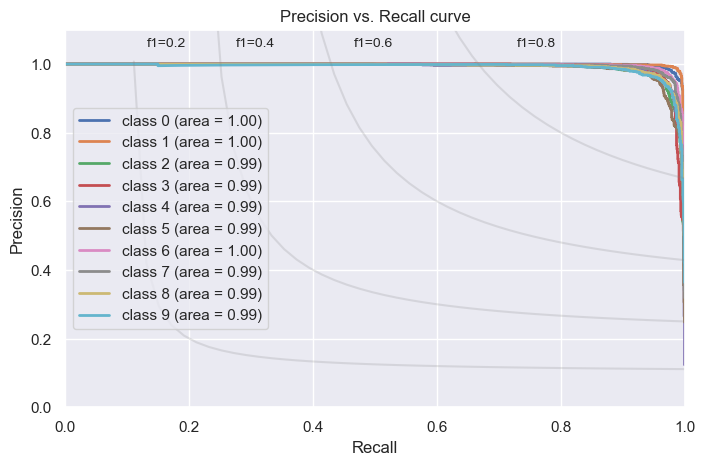




Micro-averaged precision-recall curve, Model: Neural network


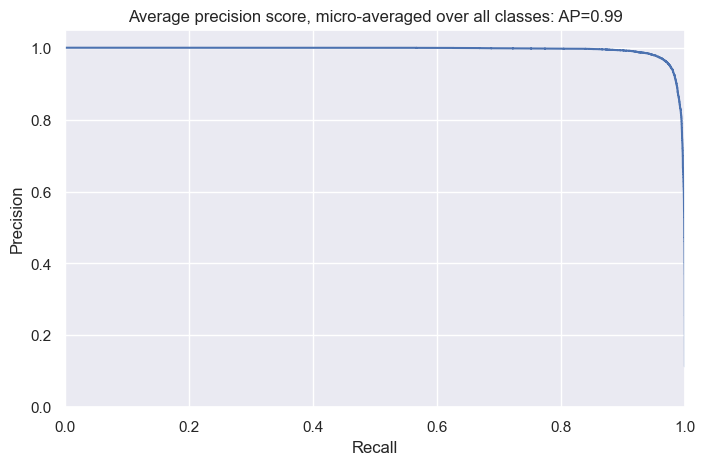

In [25]:
analyze_model_performance(y_validate, y_predicted, y_score_nn, 'Neural network')

## 5. Comparing between classification models

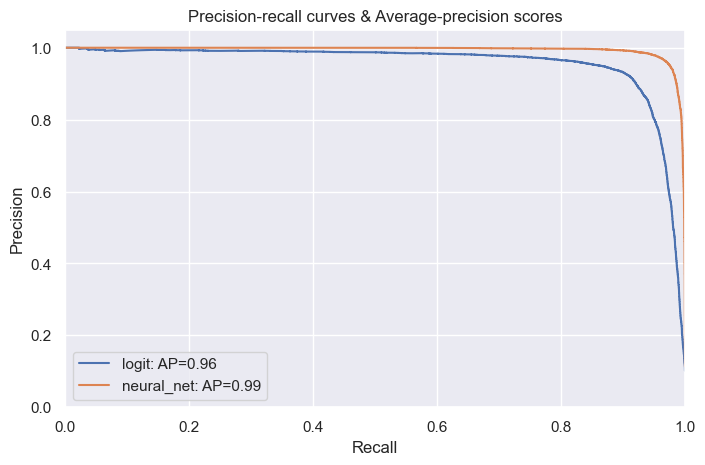

In [26]:
# plot precision-recall curve for each model
fig, ax = plt.subplots()
ax = set_ax_params(ax)
for i in range(len(list(y_scores.items()))):  
    model_name, y_score = list(y_scores.items())[i][0], list(y_scores.items())[i][1]
    micro_avg_prec_recall(ax, y_validate_binarized, y_score, model_name)
plt.title('Precision-recall curves & Average-precision scores')  
plt.legend(loc="best")
plt.show()

### Inspecting false negatives for a chosen class

False negatives for class=1:
[2 9 2 8 5 3 5 6 3 7 8 6 2 2 9 8 2 7]


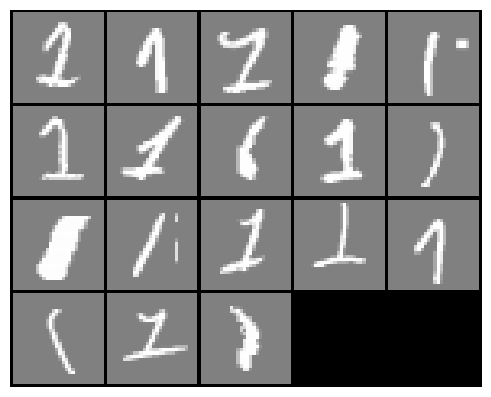

In [27]:
inspected_class = 1
false_negatives = y_predicted[y_validate == inspected_class] != inspected_class
print('False negatives for class={}:'.format(inspected_class))
print(y_predicted[y_validate == inspected_class][false_negatives].astype(int))
display_data(X_validate[y_validate == inspected_class][false_negatives]) 

## Next steps following the current version:
- imrovement of models already implemented (logistic regression, neural network), based on validation outputs
- implement other classification models such as kNN and SVM w/wo gaussian kernel
- compare algorithms performance